In [176]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [265]:
DIRECTIONS = {
    "r": (1, 0),
    "rb": (1, 1),
    "b": (0, 1),
    "bl": (-1, 1),
    "l": (-1, 0),
    "lt": (-1, -1),
    "t": (0, -1),
    "tr": (1, -1),
}

def move(start, direction):
    return [x + y for x, y in zip(start, direction)]

# move(start_point, DIRECTIONS["rb"])
def get_direction(start, end):
    
    start_x, start_y = start
    end_x, end_y = end
    
    if end_x > start_x and end_y > start_y:
        directions = [DIRECTIONS["r"], DIRECTIONS["rb"], DIRECTIONS["b"]]
    elif end_x > start_x and end_y == start_y:
        directions = [DIRECTIONS["tr"], DIRECTIONS["r"], DIRECTIONS["rb"]]
    elif end_x > start_x and end_y < start_y:
        directions = [DIRECTIONS["t"], DIRECTIONS["tr"], DIRECTIONS["r"]]
    elif end_x == start_x and end_y < start_y:
        directions = [DIRECTIONS["lt"], DIRECTIONS["t"], DIRECTIONS["tr"]]
    elif end_x < start_x and end_y < start_y:
        directions = [DIRECTIONS["l"], DIRECTIONS["lt"], DIRECTIONS["t"]]
    elif end_x < start_x and end_y == start_y:
        directions = [DIRECTIONS["bl"], DIRECTIONS["l"], DIRECTIONS["lt"]]
    elif end_x < start_x and end_y > start_y:
        directions = [DIRECTIONS["b"], DIRECTIONS["bl"], DIRECTIONS["l"]]
    elif end_x == start_x and end_y > start_y:
        directions = [DIRECTIONS["rb"], DIRECTIONS["b"], DIRECTIONS["bl"]]
        
    return [move(start, direct) for direct in directions]

def __serialize(cords):
    return ",".join([str(x) for x in cords])

def __deserialize(cords_str):
    return tuple(cords_str.split(","))

def __check_valid(cords):
    return True

def add_visited(cords, visited=set()):
    cords_str = __serialize(cords)
    visited.add(cords_str)
    return visited



def filter_pos_by_minvalue(feats_array, cords):
    feats_selected = np.array([feats_array[x,y] for x, y in cords])
    # feats_selected = np.array([1,1,1])
    mask = (feats_selected == feats_selected.min())

    if mask.sum() == 1:
        next_idx = [feats_selected.argmin()]
    else:
        next_idx = [idx for idx, val in enumerate(mask) if val]
    
    return [cords[idx] for idx in next_idx]


def filter_pos_by_mindist(end, cords):
    
    rst = []
    for vec in cords:
        dist = sum([(x-y)**2 for x,y in zip(vec, end)])
        rst += [dist]
    rst = np.array(rst)
        
    mask = (rst == rst.min())

    if mask.sum() == 1:
        next_idx = [rst.argmin()]
    else:
        next_idx = [idx for idx, val in enumerate(mask) if val]
        
    return [cords[idx] for idx in next_idx]

def process_one_round(current_pos, end, visited):
    next_pos = get_direction(current_pos, end)
    next_pos = [x for x in next_pos if __serialize(x) not in visited]
    next_pos = [x for x in next_pos if __check_valid(x)]
    
    for cord in next_pos:
        visited = add_visited(cord, visited=visited)
        
    if end in next_pos:
        return [end], visited
    else:
        # print("next position:", next_pos)
        if len(next_pos)>1:
            next_pos = filter_pos_by_minvalue(MESC*-1, next_pos)
            # print("MESV:")
            # print([(MESC[x][y], x, y) for x,y in next_pos])
        if len(next_pos)>1:
            next_pos = filter_pos_by_minvalue(ERV, next_pos)
            # print("ERV:")
            # print([(ERV[x][y], x, y) for x,y in next_pos])
        if len(next_pos)>1:
            next_pos = filter_pos_by_mindist(end, next_pos)

        return next_pos, visited
    
def visualize(mesc, erv, path_pool):
    
    plot = np.ones_like(mesc).astype(float)
    for path in path_pool:
        l = len(path) * 4
        for idx, (row, col) in enumerate(path):
            # print(float(idx) / l, idx, l)
            plot[row, col] = float(idx) / l
    
    fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(20, 5))
    sns.heatmap(pd.DataFrame(plot), ax=ax0, annot=True, cbar=False)
    sns.heatmap(pd.DataFrame(mesc), ax=ax1, annot=True, cmap='YlGnBu', cbar=False)
    sns.heatmap(pd.DataFrame(erv), ax=ax2,  annot=True, cmap='Reds', cbar=False)
    
    
    # ax2.set_xticks([])
    # ax2.set_yticks([])
    
    # display(plot, mesc, erv)
    return fig    
    
def main(start, end):
    
    visited = add_visited(start, set())
    queue = [(start, [start], visited)]
    path_pool = []

    while queue:
        # print("queue:", queue)
        current_pos, path, visited = queue.pop()
        
        if current_pos == end:
            path_pool.append(path)
            continue
        
        next_pos, visited_new = process_one_round(current_pos, end, visited)
        for cord in next_pos:
            path_new = path.copy() + [cord]
            item = (cord, path_new, visited_new)
            queue.append(item)
            
    return path_pool


In [266]:
ERV = pd.read_csv("/Users/tuanzai/Desktop/Canada/001.UBC/block_capstone/花姐项目/simple_landscape_analysis/history/2.4.4/案例/erv.csv").values
MESC =  pd.read_csv("/Users/tuanzai/Desktop/Canada/001.UBC/block_capstone/花姐项目/simple_landscape_analysis/history/2.4.4/案例/mesc.csv").values

### 开始测试

✅ 案例一

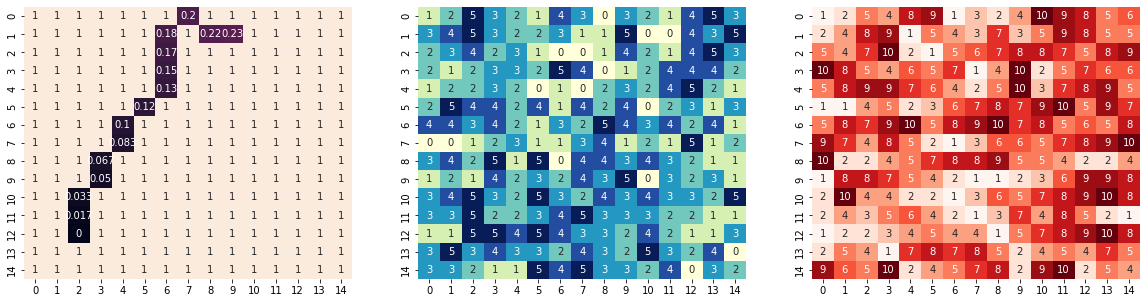

In [267]:
start = [12, 2]
end = [1, 9]
path_pool = main(start, end)

visualize(MESC, ERV, path_pool);

✅ 案例二

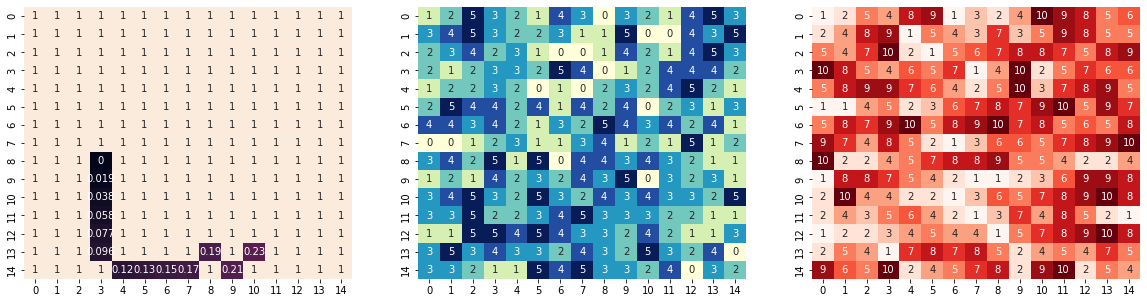

In [268]:
start = [8, 3]
end = [13, 10]
path_pool = main(start, end)

visualize(MESC, ERV, path_pool);

✅ 案例三

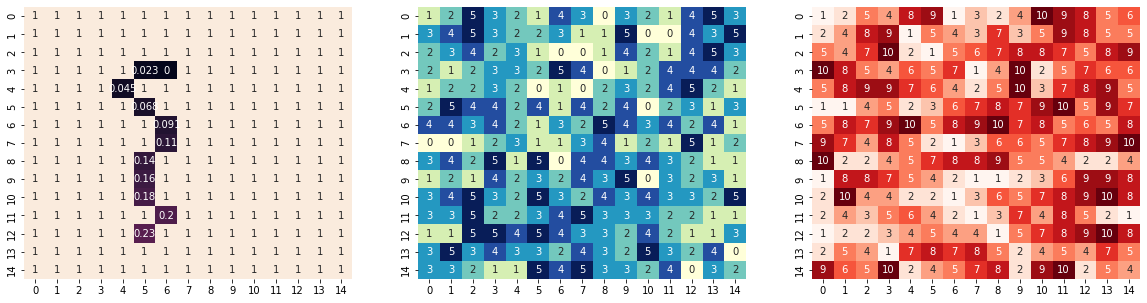

In [269]:
start = [3, 6]
end = [12, 5]
path_pool = main(start, end)

visualize(MESC, ERV, path_pool);

✅ 案例四

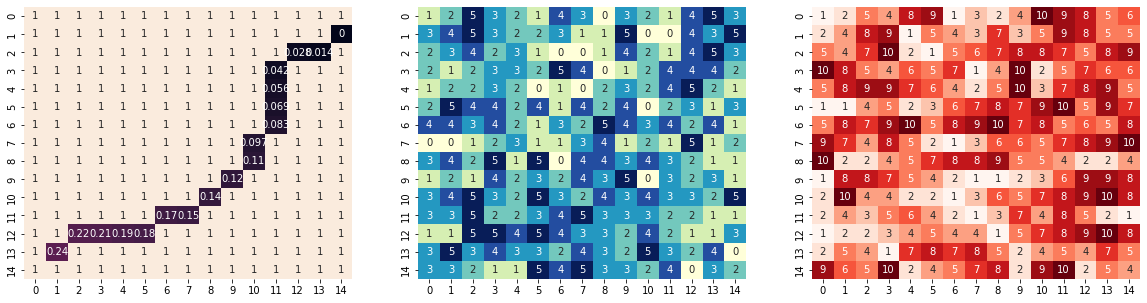

In [270]:
start = [1, 14]
end = [13, 1]
path_pool = main(start, end)

visualize(MESC, ERV, path_pool);

✅ 案例五

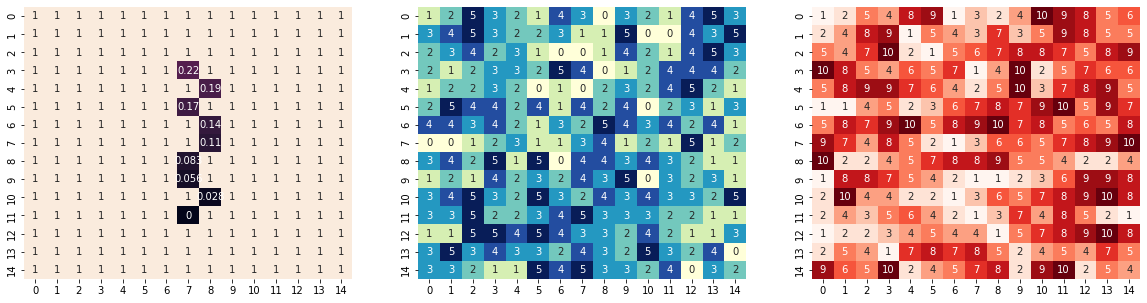

In [271]:
start = [11, 7]
end = [3, 7]
path_pool = main(start, end)

visualize(MESC, ERV, path_pool);

✅ 案例六

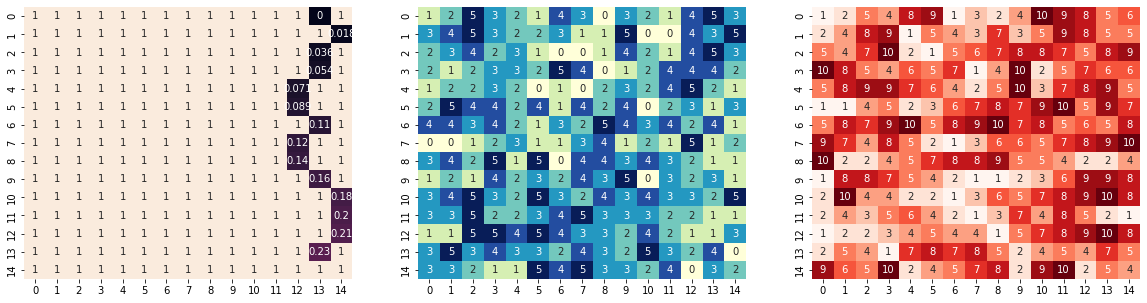

In [272]:
start = [0, 13]
end = [13, 13]
path_pool = main(start, end)

visualize(MESC, ERV, path_pool);

✅ 案例七

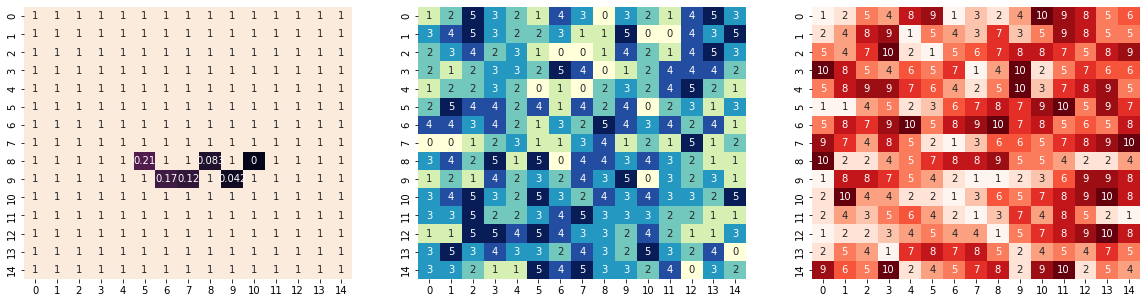

In [273]:
start = [8, 10]
end = [8, 5]
path_pool = main(start, end)

visualize(MESC, ERV, path_pool);

✅ 案例八

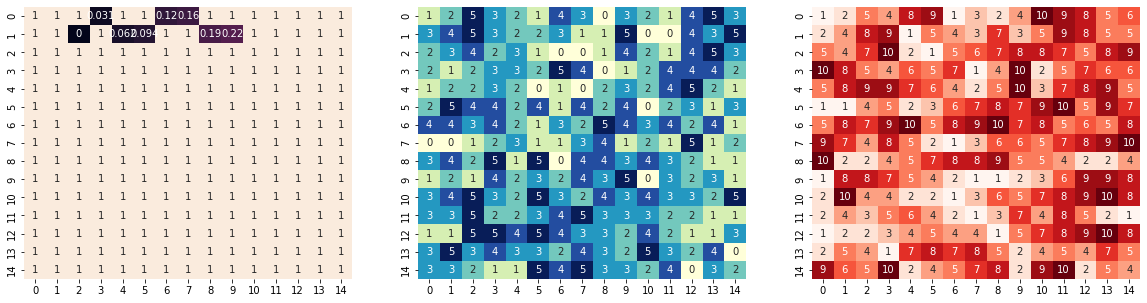

In [274]:
start = [1, 2]
end = [1, 9]
path_pool = main(start, end)

visualize(MESC, ERV, path_pool);

### 自己造一些返回多个点案例